In [ ]:
!pip install -q tensorflow-gpu==2.0.0-rc1

In [ ]:
!pip install tf-nightly-gpu

In [ ]:
!pip install import_ipynb

In [ ]:
# mount to your google drive
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

In [ ]:
#ipynb 모듈 불러오기 위한 설정(model import)
import sys
sys.path.append('/content/gdrive/My Drive/CNN/')
sys.path

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import Sequence

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, auc
from sklearn.model_selection import train_test_split
from PIL import Image

import math
import glob
import os
import numpy as np
import cv2
import pickle

import matplotlib.pyplot as plt
import albumentations as A
import seaborn as sns
import pandas as pd

import import_ipynb
from model_code import EFFICIENTNET_B0_7, MobileNet_V1, VggNet, ResNet, DenseNet

print(tf.__version__)

## 설정(텐서, 배치, 스텝, 에폭, csv 등.)

In [ ]:
#train, test, sample csv 읽어오기
train = pd.read_csv('/content/gdrive/My Drive/cvpr_data/train.csv', index_col=None)
test = pd.read_csv('/content/gdrive/My Drive/cvpr_data/test.csv', index_col=None)
sample = pd.read_csv('/content/gdrive/My Drive/cvpr_data/sample_submission.csv', index_col=None)

#root_path 경로 설정.
ROOT_PATH = '/content/gdrive/My Drive/cvpr_data/images'

# 이미지 설정(train : 1821, test : 1821)
IMAGE_SHAPE = [342, 512, 3]

train_batch = 30
val_batch = 30
test_batch = 1

train_step = 80
val_step = 20
test_step = 1
epoch = 100
history = {}

#classes
NUM_CLASSES = 4
CLASSES = ['healthy', 'multiple_diseases', 'rust', 'scab']

## 모델 선택(해당 모델 번호 입력) 

In [ ]:
def get_models(model_select, NUM_CLASSES):
  if model_select == 1:
    return VggNet.vgg_11(NUM_CLASSES)
  elif model_select == 2:
    return VggNet.vgg_13(NUM_CLASSES)
  elif model_select == 3:
    return VggNet.vgg_16(NUM_CLASSES)
  elif model_select == 4:
    return VggNet.vgg_19(NUM_CLASSES)
  elif model_select == 5:
    return VggNet.se_vgg_16(NUM_CLASSES)
  elif model_select == 6:
    return VggNet.se_vgg_19(NUM_CLASSES)
  elif model_select == 7:
    return VggNet.cbam_vgg_16(NUM_CLASSES)
  elif model_select == 8:
    return VggNet.cbam_vgg_19(NUM_CLASSES)
  elif model_select == 9:
    return ResNet.resnet_18(NUM_CLASSES)
  elif model_select == 10:
    return ResNet.resnet_34(NUM_CLASSES)
  elif model_select == 11:
    return resnet.resnet_50(NUM_CLASSES)
  elif model_select == 12:
    return ResNet.resnet_101(NUM_CLASSES)
  elif model_select == 13:
    return ResNet.resnet_152(NUM_CLASSES)
  elif model_select == 14:
    return ResNet.se_resnet_50(NUM_CLASSES)
  elif model_select == 15:
    return ResNet.se_resnet_101(NUM_CLASSES)
  elif model_select == 16:
    return ResNet.se_resnet_152(NUM_CLASSES)
  elif model_select == 17:
    return ResNet.cbam_resnet_50(NUM_CLASSES)
  elif model_select == 18:
    return ResNet.cbam_resnet_101(NUM_CLASSES)
  elif model_select == 19:
    return ResNet.cbam_resnet_152(NUM_CLASSES)
  elif model_select == 20:
    return DenseNet.densenet_121(NUM_CLASSES)
  elif model_select == 21:
    return DenseNet.densenet_169(NUM_CLASSES)
  elif model_select == 22:
    return DenseNet.densenet_201(NUM_CLASSES)
  elif model_select == 23:
    return DenseNet.densenet_265(NUM_CLASSES)
  elif model_select == 24:
    return DenseNet.se_densenet_121(NUM_CLASSES)
  elif model_select == 25:
    return DenseNet.se_densenet_169(NUM_CLASSES)
  elif model_select == 26:
    return DenseNet.se_densenet_201(NUM_CLASSES)
  elif model_select == 27:
    return DenseNet.se_densenet_265(NUM_CLASSES)
  elif model_select == 28:
    return DenseNet.cbam_DenseNet_121(NUM_CLASSES)
  elif model_select == 29:
    return DenseNet.cbam_DenseNet_169(NUM_CLASSES)
  elif model_select == 30:
    return DenseNet.cbam_DenseNet_201(NUM_CLASSES)
  elif model_select == 31:
    return DenseNet.cbam_DenseNet_265(NUM_CLASSES)
  elif model_select == 32:
    return EFFICIENTNET_B0_7.efficient_net_b0(NUM_CLASSES)
  elif model_select == 33:
    return EFFICIENTNET_B0_7.efficient_net_b1(NUM_CLASSES)
  elif model_select == 34:
    return EFFICIENTNET_B0_7.efficient_net_b2(NUM_CLASSES)
  elif model_select == 35:
    return EFFICIENTNET_B0_7.efficient_net_b3(NUM_CLASSES)
  elif model_select == 36:
    return EFFICIENTNET_B0_7.efficient_net_b4(NUM_CLASSES)
  elif model_select == 37:
    return EFFICIENTNET_B0_7.efficient_net_b5(NUM_CLASSES)
  elif model_select == 38:
    return EFFICIENTNET_B0_7.efficient_net_b6(NUM_CLASSES)
  elif model_select == 39:
    return EFFICIENTNET_B0_7.efficient_net_b7(NUM_CLASSES)
  elif model_select == 40:
    return EFFICIENTNET_B0_7.cbam_efficient_net_b0(NUM_CLASSES)
  elif model_select == 41:
    return EFFICIENTNET_B0_7.cbam_efficient_net_b1(NUM_CLASSES)
  elif model_select == 42:
    return EFFICIENTNET_B0_7.cbam_efficient_net_b2(NUM_CLASSES)
  elif model_select == 43:
    return EFFICIENTNET_B0_7.cbam_efficient_net_b3(NUM_CLASSES)
  elif model_select == 44:
    return EFFICIENTNET_B0_7.cbam_efficient_net_b4(NUM_CLASSES)
  elif model_select == 45:
    return EFFICIENTNET_B0_7.cbam_efficient_net_b5(NUM_CLASSES)
  elif model_select == 46:
    return EFFICIENTNET_B0_7.cbam_efficient_net_b6(NUM_CLASSES)
  elif model_select == 47:
    return EFFICIENTNET_B0_7.cbam_efficient_net_b7(NUM_CLASSES)
  elif model_select == 48:
    return MobileNet_V1.MobileNet_V1(NUM_CLASSES)
  elif model_select == 49:
    return MobileNet_V1.se_MobileNet_V1(NUM_CLASSES)
  elif model_select == 50:
    return MobileNet_V1.cbam_MobileNet_V1(NUM_CLASSES)
  elif model_select == 51:
    return EFFICIENTNET_B0_7.efficientnet_b0(NUM_CLASSES)
  else:
    raise ValueError("The model_index does not exist.")

In [ ]:
model_select = int(input('Please enter the model index you want to use.'))

Please enter the model index you want to use.40


In [ ]:
get_model = get_models(model_select, NUM_CLASSES)

## Dataset Directory & Data loader Implementation  

In [ ]:
#albumentations Module 설정.
transforms_train = A.Compose([
    A.Resize(height=IMAGE_SHAPE[0], width=IMAGE_SHAPE[1], p=1.0),
    A.RandomCrop(height=IMAGE_SHAPE[0]-2, width=IMAGE_SHAPE[1]-2, p=1.0),
    A.Resize(height=IMAGE_SHAPE[0], width=IMAGE_SHAPE[1], p=1.0),
    A.Flip(),
    A.ShiftScaleRotate(rotate_limit=40.0, p=0.8),
    A.HorizontalFlip(p=0.5)
])

transforms_valid = A.Compose([
    A.Resize(height=IMAGE_SHAPE[0], width=IMAGE_SHAPE[1], p=1.0)
])

transforms_test = A.Compose([
    A.Resize(height=IMAGE_SHAPE[0], width=IMAGE_SHAPE[1], p=1.0)
])

In [ ]:
images = []
test_images = []

image_ids = list(train.image_id)
test_ids = list(test.image_id)

for image_id in image_ids:
  images.append(os.path.join(ROOT_PATH,image_id) + '.jpg')

for test_id in test_ids:
  test_images.append(os.path.join(ROOT_PATH, test_id) + '.jpg')

labels = list(zip(train.healthy, train.multiple_diseases, train.rust, train.scab))
test_labels = []

train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size = 0.2, random_state=2020, stratify=labels)

In [ ]:
print(len(train_images), len(val_images), len(train_labels), len(val_images), len(images), len(labels))

1456 365 1456 365 1821 1821


In [ ]:
train_images[0], val_images[0]

('/content/gdrive/My Drive/cvpr_data/images/Train_1713.jpg',
 '/content/gdrive/My Drive/cvpr_data/images/Train_301.jpg')

(1365, 2048, 3)
(1365, 2048, 3)


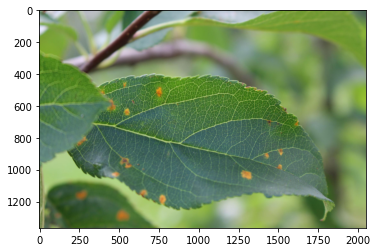

In [ ]:
img = plt.imread(train_images[0])
print(img.shape)
plt.imshow(img)

img = plt.imread(val_images[0])
print(img.shape)
plt.imshow(img)

In [ ]:
# 데이터 확인 함수
def check_images(labels, classes):
  healthy = labels.healthy
  multiple_diseases = labels.multiple_diseases
  rust =labels.rust
  scab= labels.scab

  num_healthy = [len([i for i in healthy if i == 1]), len([i for i in healthy if i == 0])]
  num_multiple = [len([i for i in multiple_diseases if i == 1]), len([i for i in multiple_diseases if i == 0])]
  num_rust = [len([i for i in rust if i == 1]), len([i for i in rust if i == 0])]
  num_scab = [len([i for i in scab if i == 1]), len([i for i in scab if i == 0])]

  pos = [num_healthy[0], num_multiple[0], num_rust[0], num_scab[0]]
  nev = [num_healthy[1], num_multiple[1], num_rust[1], num_scab[1]]

  plt.rcParams["font.size"] = 12

  plt.figure(figsize=(12,8))

  x = np.arange(len(classes))
  p1 = plt.bar(x-0.15, pos, width=0.3, color='#FF0000', label = 1, alpha=0.5)
  plt.xticks(x, classes)
  p2 = plt.bar(x+0.15, nev, width=0.3, color='#0000FF', label = 0, alpha = 0.5)
  plt.xticks(x, classes)

  for i, rect in enumerate(p1):
      plt.text(rect.get_x() + rect.get_width() / 2.0, 0.95 * rect.get_height(), str(pos[i]), ha='center')
  for i, rect in enumerate(p2):
      plt.text(rect.get_x() + rect.get_width() / 2.0, 0.95 * rect.get_height(), str(nev[i]), ha='center')
  plt.legend((p1[0], p2[0]), ('1','0'), fontsize = 15)

  plt.show()

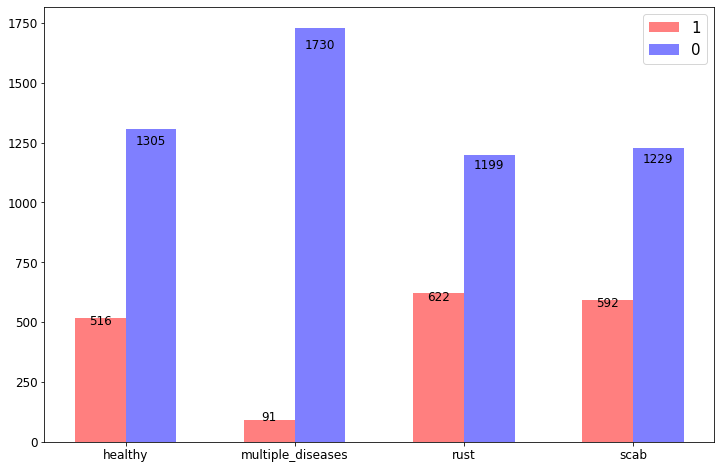

In [ ]:
check_images(train, CLASSES)

In [ ]:
class Classification_Dataset:
    # class_list -> image_labels 변경
    def __init__(self, image_paths = "", one_hot_label = None, integers_label = None, target_size = None, augment = None):
        
        self.image_list = image_paths
        self.one_hot_label = one_hot_label
        self.integers_label = integers_label
        self.target_size = target_size
        self.augment = augment
    
    
    def __len__(self):
      if self.one_hot_label:
        return len(self.image_list)
      elif self.integers_label:
        return len(self.integers_label)

    
    def __getitem__(self, idx):
        image = cv2.imread(self.image_list[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image/255.0

        if self.one_hot_label:
          label = self.one_hot_label[idx]
        
        if self.integers_label:
          label = 0

          for i in range(len(self.integers_label)):
            if(self.integers_label[i] in self.image_list[idx]):
                label = i
                break             

        
        if self.augment:
            transformed = self.augment(image=image)
            image = transformed['image']

        #albumentations module 따로 설정함.
        #image = image.resize(self.target_size)
        return image, label

In [ ]:
class Classification_Data_Loader(Sequence):

    def __init__(self, dataset, batch_size=None, shuffle=False):
        
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle=shuffle
        self.index_list = [idx for idx in range(len(self.dataset))]
        self.idx=0
        
    def __getitem__(self, idx):
      
        start = idx * self.batch_size
        end = (idx+1) * self.batch_size
        data = []
        label = []
        
        if self.shuffle:
            np.random.shuffle(self.index_list)
            
        for j in range(start,end):
            if j >= len(self.index_list):
                j%=len(self.dataset)
            data.append(self.dataset[self.index_list[j]])
      
        batch = tuple(tf.stack(sample, axis=0) for sample in zip(*data))

        if self.idx >= (len(self.dataset)//self.batch_size):
            self.idx=0
        self.idx +=1
        return batch

    def __call__(self):
        batch = self.__getitem__(self.idx)
        return batch

    def __len__(self):
        return (len(self.dataset) // self.batch_size)

    def get_batch(self):
        return self.batch_size

In [ ]:
# 데이터 로더 동작 확인
def data_info_print(data_gen, idx):
  batch = data_gen.__getitem__(idx)
  print(type(batch), type(batch[0]), type(batch[1]))
  # 변경
  print(len(batch[0]), len(batch[1]))
  plt.figure(figsize=(20,8))
  for i in range(len(batch[0])):
    plt.subplot(6,5,i+1)
    # 변경 
    plt.imshow(batch[0][i])
    
  print('label :', batch[1])
  print(type(batch[0][0]), type(batch[1][0]))

## 데이터 확인 & 데이터 로더 생성



In [ ]:
train_dataset = Classification_Dataset(image_paths=train_images, one_hot_label = train_labels, augment = transforms_train)
valid_dataset = Classification_Dataset(image_paths=val_images, one_hot_label = val_labels, augment = transforms_valid)
test_dataset = Classification_Dataset(image_paths=images, one_hot_label = labels, augment = transforms_test)

train_data_gen = Classification_Data_Loader(dataset=train_dataset, batch_size=train_batch, shuffle=True)
valid_data_gen = Classification_Data_Loader(dataset=valid_dataset, batch_size=val_batch, shuffle=True)
test_data_gen = Classification_Data_Loader(dataset=test_dataset, batch_size=test_batch)

images, labels = train_data_gen.__getitem__(0)
print(labels)

tf.Tensor(
[[0 0 0 1]
 [1 0 0 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 1 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]], shape=(30, 4), dtype=int32)


In [ ]:
image, label = test_data_gen.__getitem__(0)
print(image.shape)

(1, 342, 512, 3)


<class 'tuple'> <class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
30 30
label : tf.Tensor(
[[0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 1 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 1 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 1 0]
 [1 0 0 0]
 [0 0 1 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]
 [0 0 1 0]
 [0 0 1 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 1 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [1 0 0 0]], shape=(30, 4), dtype=int32)
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>


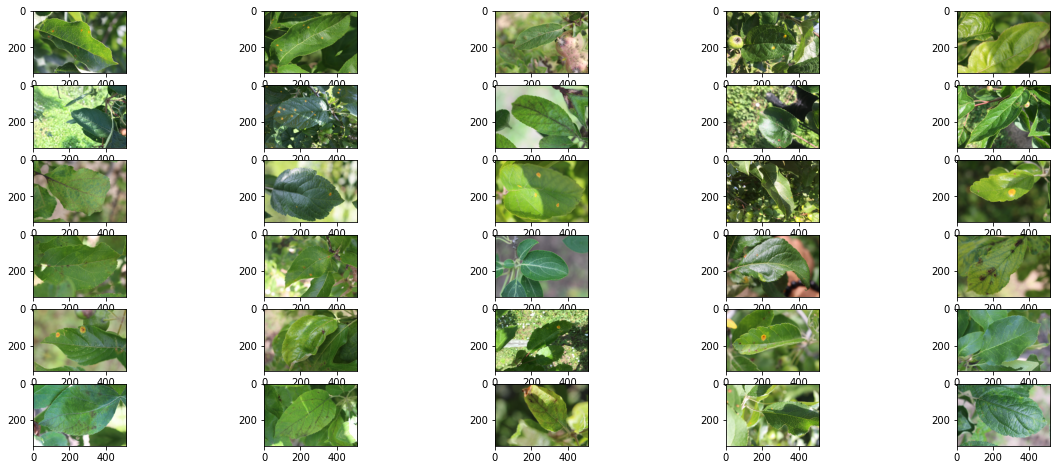

In [ ]:
data_info_print(train_data_gen,0)

# 모델 훈련  
### Using GradientTape


In [ ]:
def fit_test(model, train_gen, train_steps, epochs, val_gen, val_steps):
    BATCH_SIZE = train_gen.get_batch()
  # define loss and optimizer
    optimizer = keras.optimizers.Adam(learning_rate=0.00001)
    loss_func = keras.losses.CategoricalCrossentropy()

    train_loss = tf.keras.metrics.Mean(name='train_loss')
    train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')

    valid_loss = tf.keras.metrics.Mean(name='valid_loss')
    valid_accuracy = tf.keras.metrics.CategoricalAccuracy(name='valid_accuracy')

    train_losses = []
    train_acces = []
    val_losses = []
    val_acces = []

    @tf.function
    def train_step(images, labels):
        with tf.GradientTape() as tape:
            predictions = model(images, training=True)
            loss = loss_func(y_true=labels, y_pred=predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(grads_and_vars=zip(gradients, model.trainable_variables))

        train_loss(loss)
        train_accuracy(labels, predictions)

    @tf.function
    def valid_step(images, labels):

        predictions = model(images, training=False)
        v_loss = loss_func(labels, predictions)

        valid_loss(v_loss)
        valid_accuracy(labels, predictions)

    def step_decay(epoch, train_accuracy):
        if epoch <= 1:
          return True

        if 0.950 > train_accuracy > 0.880 :
          optimizer.learning_rate = 0.0001
          print("lr : ", optimizer.learning_rate)

        if train_accuracy > 0.950 :
          optimizer.learning_rate = 0.00001
          print("lr : ", optimizer.learning_rate)

  # start training
    for epoch in range(epochs):
        train_loss.reset_states()
        train_accuracy.reset_states()
        valid_loss.reset_states()
        valid_accuracy.reset_states()
        #step = 0
        for step in range(train_steps):
            print('.',end='')
            if step % 100 == 0:
                print()
            images, labels = train_gen()
            train_step(images, labels)
            
        print('x')
        
        for val_step in range(val_steps):
            print('.', end='')
            if val_step % 100 == 0:
                print()
            valid_images, valid_labels = val_gen()
            valid_step(valid_images, valid_labels)
        print('x')
        print("Epoch: {}/{}, train loss: {:.5f}, train accuracy: {:.5f}, "
              "valid loss: {:.5f}, valid accuracy: {:.5f}".format(epoch + 1,
                                                                epochs,
                                                                train_loss.result(),
                                                                train_accuracy.result(),
                                                                valid_loss.result(),
                                                                valid_accuracy.result()))
        #step_decay(epoch, train_accuracy.result())

        train_losses.append(train_loss.result())
        train_acces.append(train_accuracy.result())
        val_losses.append(valid_loss.result())
        val_acces.append(valid_accuracy.result())

    history = {'train_losses': train_losses, 'train_acces': train_acces, 'val_losses': val_losses, 'val_acces': val_acces}
    return history

In [ ]:
 def test_eval(model, test_data_gen, test_steps):
  loss_func = keras.losses.CategoricalCrossentropy()
  test_loss = tf.keras.metrics.Mean()
  test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')

  @tf.function
  def test_step(images, labels):
      predictions = model(images, training=False)
      t_loss = loss_func(labels, predictions)  

      test_loss(t_loss)
      test_accuracy(labels, predictions)

  for step in range(test_steps):
    print('.',end='')
    if step % 100 == 0:
      print()
    test_images, test_labels = test_data_gen()
    test_step(test_images, test_labels)
  print('x')
  print("loss: {:.5f}, test accuracy: {:.5f}".format(test_loss.result(),
                                                      test_accuracy.result()))

  #print("The accuracy on test set is: {:.3f}%".format(test_accuracy.result()*100))

In [ ]:
get_models.build(input_shape=(None, IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]))

In [ ]:
get_models.summary()

Model: "efficient_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  896       
_________________________________________________________________
batch_normalization (BatchNo multiple                  128       
_________________________________________________________________
sequential (Sequential)      (None, 171, 256, 16)      2776      
_________________________________________________________________
sequential_1 (Sequential)    (None, 86, 128, 24)       30828     
_________________________________________________________________
sequential_2 (Sequential)    (None, 43, 64, 40)        81904     
_________________________________________________________________
sequential_3 (Sequential)    (None, 22, 32, 80)        467100    
_________________________________________________________________
sequential_4 (Sequential)    (None, 22, 32, 112)     

In [ ]:
history = fit_test(model=get_models, 
                   train_gen=train_data_gen, 
                   train_steps=train_step, 
                   epochs=epoch, 
                   val_gen=valid_data_gen, 
                   val_steps=val_step)

## 저장(Model, history, predict)

In [ ]:
get_models.save_weights('/content/gdrive/My Drive/CNN/save_model/EfficientNet/cbam_min2_efficientnet_b0_epoch_100', save_format='tf')

In [ ]:
with open('/content/gdrive/My Drive/CNN/save_history/EfficientNet/all_cbam_min2_efficientnet_b0_epoch_100.bin', 'wb') as hi:
  pickle.dump(total_history, hi)

In [ ]:
with open('/content/gdrive/My Drive/CNN/save_predict/EfficientNet/all_cbam_min2_efficientnet_b0.bin', 'wb') as hi:
  pickle.dump(predict_set, hi)

## 로드(Model, history, predict)

In [ ]:
get_model.load_weights('/content/gdrive/My Drive/CNN/save_model/EfficientNet/cbam_min2_efficientnet_b0_epoch_80')   

In [ ]:
with open('/content/gdrive/My Drive/CNN/save_history/EfficientNet/cbam_min2_efficientnet_b0_epoch_50.bin', 'rb') as f:
  history_1 = pickle.load(f)
with open('/content/gdrive/My Drive/CNN/save_history/EfficientNet/cbam_min2_efficientnet_b0_epoch_80.bin', 'rb') as f:
  history_2 = pickle.load(f)
with open('/content/gdrive/My Drive/CNN/save_history/EfficientNet/cbam_min2_efficientnet_b0_epoch_100.bin', 'rb') as f:
  history_3 = pickle.load(f)

In [ ]:
li_train_loss = history_1['train_losses'] + history_2['train_losses'] + history_3['train_losses']
li_train_acc = history_1['train_acces'] + history_2['train_acces'] + history_3['train_acces']
li_val_loss = history_1['val_losses'] + history_2['val_losses'] + history_3['val_losses']
li_val_acc = history_1['val_acces'] + history_2['val_acces'] + history_3['val_acces']

In [ ]:
total_history = dict(zip(['train_losses', 'train_acces', 'val_losses', 'val_acces'], [li_train_loss, li_train_acc, li_val_loss, li_val_acc]))

In [ ]:
with open('/content/gdrive/My Drive/CNN/save_predict/EfficientNet/all_vgg16_epoch_100_predict_list.bin', 'rb') as f:
  predict_set = pickle.load(f)

## 평가(Model, history, predict)

In [ ]:
test_eval(get_models, test_data_gen, 1821)

.

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.

# 모델 학습 가시화 그래프


In [ ]:
#y축(accuracy, loss) 범위를 0 ~ 1 조정해서 보여줌.  - 조정을 안하면 값의 범위가 커짐으로써 그래프를 자세히 보기 어려워짐.
def his_graph(history, epoch):
  acc = history['train_acces']
  val_acc = history['val_acces']

  loss = history['train_losses']
  val_loss = history['val_losses']

  epochs_range = range(epoch)

  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')

  plt.ylim(0, 1)
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')

  plt.show()

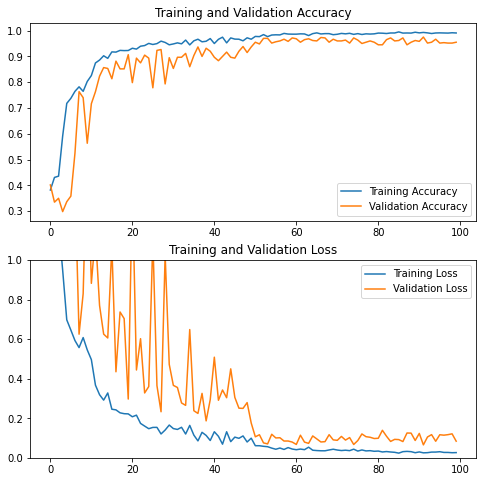

In [ ]:
his_graph(total_history, 100)

#모델 예측 및 가시화(confusion matrix)

In [ ]:
def model_predict(model, test_gen, steps):
  predics=[]
  labels = []
  for step in range(steps):
    if step % 100 == 0:
      print(step, end=',')

    image, label = test_gen.__getitem__(step)
    pred = model.predict(image)
    labels.append(label)
    predics.append(pred)
  re_dic = dict({'pred':predics, 'labels':labels})
  return re_dic

In [ ]:
def pred_confusion_matrix(pred, labels):
  
  pred_int = []
  label_int = []
  index_int = []

  for i, j in enumerate(range(len(pred))):
    index_int.append(j)
    # print("{} :".format(i), pred[j][0], sep='  ')
    max_value = max(pred[j][0])
    for u in range(4):
      index_value = pred[j][0][u]
      if max_value == index_value:
        #print('{}data :'.format(i), max_value, 'index : {}'.format(u))
        pred_int.append(u)
      if labels[j][0][u] == 1:
        label_int.append(u)



  print('pred :', len(pred_int), ', label :', len(label_int))
  print('Confusion Matrix')
  conf_matrix = confusion_matrix(label_int, pred_int)
  #print(conf_matrix)
  print('classes - 0 : healthy, 1 : combinations, 2 : rust, 3 : scab')
  sns.heatmap(conf_matrix,cmap="Blues", annot=True, fmt='g')
  plt.xlabel('predicted value')
  plt.ylabel('true value')

  return index_int, pred_int, label_int

In [ ]:
re_dic = model_predict(get_models, test_data_gen, 1821)
pred = re_dic['pred']
labels = re_dic['labels']

0,100,200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600,1700,1800,

pred : 1821 , label : 1821
Confusion Matrix
classes - 0 : healthy, 1 : combinations, 2 : rust, 3 : scab


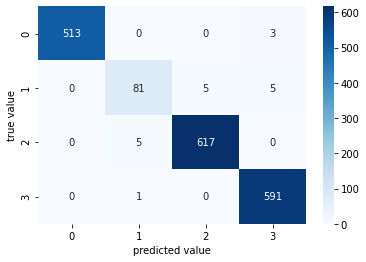

In [ ]:
predict_set = pred_confusion_matrix(pred, labels)

In [ ]:
print(len(predict_set[0]), len(predict_set[1]), len(predict_set[2]))
print(predict_set[0][0], predict_set[1][0], predict_set[2][0])

1821 1821 1821
0 3 3


## Feature Map

(1, 342, 512, 3)


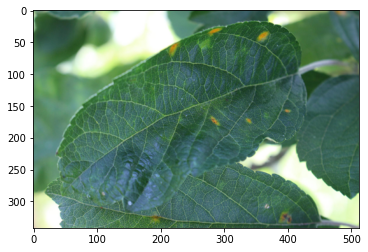

In [ ]:
#feature map 

test_image = Image.open('/content/gdrive/My Drive/cvpr_data/images/Train_58.jpg').resize((IMAGE_SHAPE[1], IMAGE_SHAPE[0]))

img_tensor = np.array(test_image)
img_tensor = np.expand_dims(img_tensor, axis=0)
test_data = img_tensor / 255.0

plt.imshow(test_image)

print(test_data.shape)

In [ ]:
#모델 예측 확인

pred_test = get_models.predict(test_data)

pred_test

array([[1.2615103e-10, 3.6591490e-07, 9.9999964e-01, 1.1327738e-12]],
      dtype=float32)

In [ ]:
feature_model = tf.keras.models.Sequential()

In [ ]:
def Layer_predict(model, image):
  inputs = tf.cast(image, tf.float32)
  show_model = model(inputs, feature_map = 'fm')
  for pred_layer in show_model:
    print(pred_layer.shape)
  
  return show_model

In [ ]:
layer_outputs = Layer_predict(get_models, test_data)

(1, 171, 256, 32)
(1, 171, 256, 32)
(1, 171, 256, 32)
(1, 171, 256, 16)
(1, 86, 128, 24)
(1, 43, 64, 40)
(1, 22, 32, 80)
(1, 22, 32, 112)
(1, 11, 16, 192)
(1, 11, 16, 320)
(1, 11, 16, 1280)
(1, 11, 16, 1280)
(1, 11, 16, 1280)
(1, 1280)
(1, 1280)
(1, 4)


In [ ]:
def show_predict_image(model, show_model_pred, i):
    n_col= 8

    if show_model_pred.ndim == 4:
      _, size2, size, n_features = show_model_pred.shape
      
      n_row = n_features // n_col
      # feature_map_image = np.zeros(shape=(size2*n_row,size*n_col),dtype=('uint8'))
      feature_map_image = np.zeros(shape=(size2,size*n_col),dtype=('uint8'))
      
      for row in range(1):
          for col in range(n_col):   
              input_fmi = show_model_pred[0,:,:,row*n_col+col]

              input_fmi -= np.mean(input_fmi)
              input_fmi /= np.std(input_fmi)
              input_fmi *= 64
              input_fmi += 128
              input_fmi = np.clip(input_fmi, 0, 255).astype('uint8')

              feature_map_image[row*size2:(row+1)*size2, col*size:(col+1)*size] = input_fmi

      plt.figure(figsize=(n_col, n_row))
      plt.xticks([])
      plt.yticks([])
      plt.title('{}'.format(model.get_layer(index=i).name))
      plt.tight_layout()
      plt.imshow(feature_map_image,cmap='viridis')

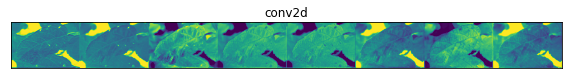

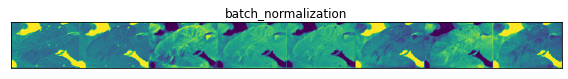

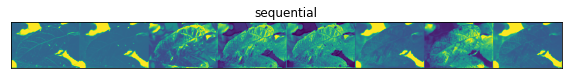

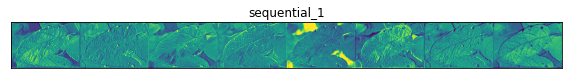

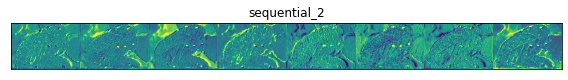

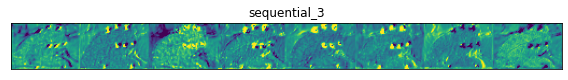

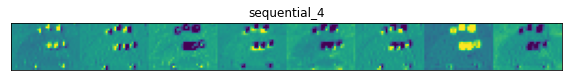

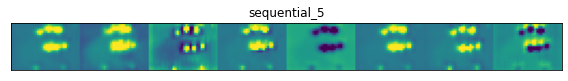

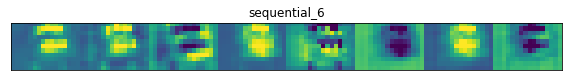

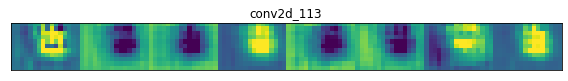

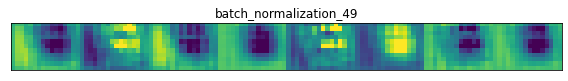

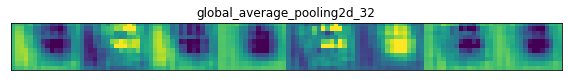

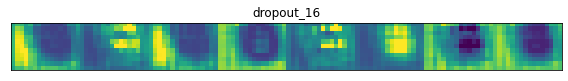

In [ ]:
for i, layer in enumerate(layer_outputs):
  show_predict_image(get_models, layer, i)
plt.tight_layout()
plt.show()

In [ ]:
#각 층의 1개의 피쳐 맵 가져오기
def show_activation_mapss(model, layer, i, n_cols=4):
  if layer.ndim == 4:
    plt.subplot(3, 5, i+1)
    plt.title('{}'.format(model.get_layer(index=i).name))
    plt.axis('off')
    plt.matshow(layer[0, :, :, i], fignum=0)

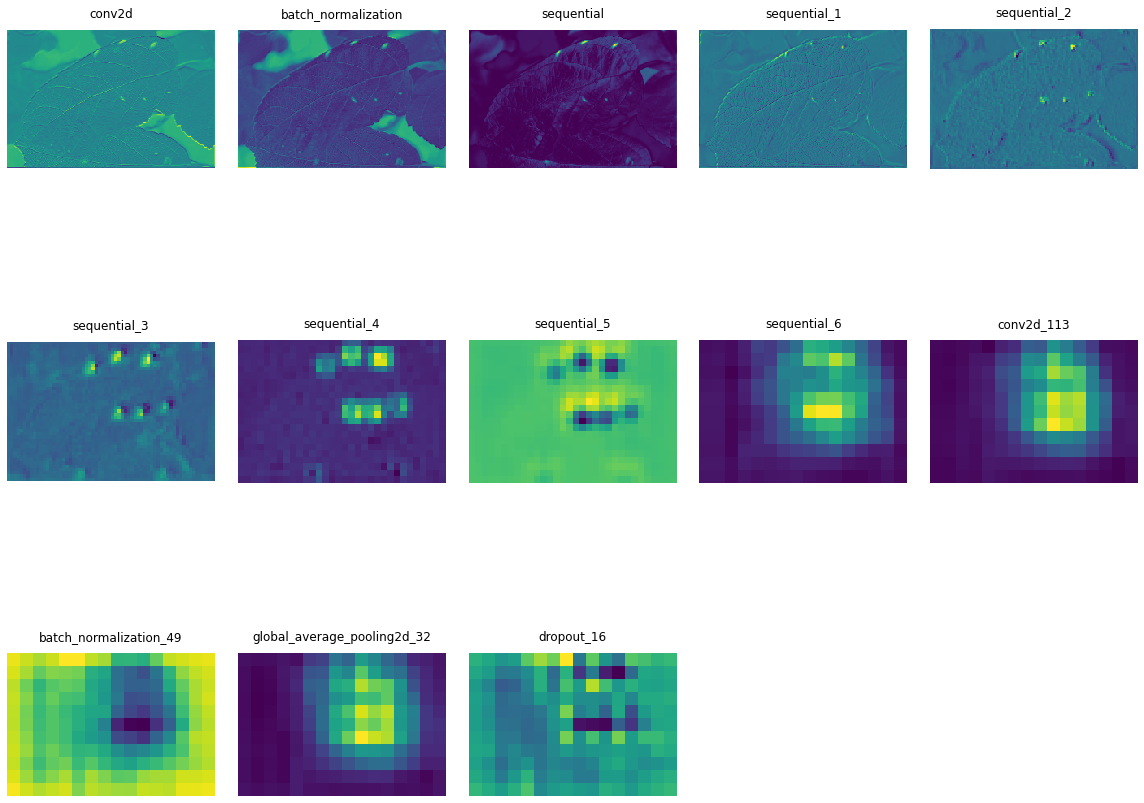

In [ ]:
plt.figure(figsize=(16, 14))
for i, layer in enumerate(layer_outputs):
  show_activation_mapss(get_models, layer, i)
plt.tight_layout()
plt.show()

#Grad CAM
######알맞게 모델 조정 필요(return output, mask)

In [ ]:
#model layer commit
for i in range(14):
  weights = get_model.get_layer(index=i).output

  print(i, weights)

In [ ]:
healthy_list = set()
multiple_diseases_list = set()
rust_list = set()
scab_list = set()

def classes_cam_list(class_set, index):
  a = b = c = d = 0

  for j in range(3):
    for i in range(1821):
      if predict_set[2][i] == index:
        if (predict_set[1][i] == 0) and (predict_set[2][i] == index) and a < 5:
          class_set.add(predict_set[0][i])
          a += 1

        elif (predict_set[1][i] == 1) and (predict_set[2][i] == index) and b < 5:
          class_set.add(predict_set[0][i])
          b += 1

        elif (predict_set[1][i] == 2) and (predict_set[2][i] == index) and c < 5:
          class_set.add(predict_set[0][i])
          c += 1
          
        elif (predict_set[1][i] == 3) and (predict_set[2][i] == index) and d < 5:
          class_set.add(predict_set[0][i])
          d += 1

    return class_set

healthy_list = list(classes_cam_list(healthy_list, 0))
multiple_diseases_list = list(classes_cam_list(multiple_diseases_list, 1))
rust_list = list(classes_cam_list(rust_list, 2))
scab_list = list(classes_cam_list(scab_list, 3))

In [ ]:
print('healthy_list, multiple_disease_list, rust, scab:', len(healthy_list), len(multiple_diseases_list), len(rust_list), len(scab_list), sep=',  ')

healthy_list, multiple_disease_list, rust, scab:,  8,  15,  10,  6


In [ ]:
def grad_cam(model, idx, class_name, class_list):
  plt.figure(figsize=(18, 15))
  for i in range(len(class_list)):
    path = os.path.join('/content/gdrive/My Drive/cvpr_data/images/Train_{}.jpg'.format(class_list[i]))
    image = cv2.imread(path)
    img = cv2.resize(image, (IMAGE_SHAPE[1], IMAGE_SHAPE[0]))
    x = img.copy()
    x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0
    
    #grad_model = tf.keras.models.Model(
    #      [resnet101.layers[0]], [resnet101.layers[-2],resnet101.layers[-1]]
    #  )
      
    with tf.GradientTape() as tape:
        inputs = tf.cast(x, tf.float32)
        model_outputs, predictions = model(inputs, cam = 'grad')
        loss = predictions[:,0]

    grads = tape.gradient(loss, model_outputs)

    guided_grads = (
          tf.cast(model_outputs > 0, "float32") * tf.cast(grads > 0, "float32") * grads
    )

    prediction = predictions[0][idx]
    model_outputs = model_outputs[0]

    plt.subplot(5, 4, i + 1)
    plt.suptitle('{} Grad CAM'.format(class_name))
    plt.title('Train_{}.jpg, pred_class : {}'.format(class_list[i], CLASSES[predict_set[1][class_list[i]]]))

    weights = np.mean(grads, axis=(1, 2))
    weights = weights.reshape(1280, 1)

    cam = (prediction -0.5) * np.matmul(model_outputs, weights)
    cam -= np.min(cam)
    cam /= np.max(cam)
    cam -= 0.2
    cam /= 0.8

    try:
      cam = cv2.resize(np.float32(cam), (IMAGE_SHAPE[1], IMAGE_SHAPE[0]))
    except Exception as e:
      #print(cam.shape)
      print(str(e))

    heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heatmap[np.where(cam <= 0.2)] = 0
    grad_cam = cv2.addWeighted(img, 0.8, heatmap, 0.4, 0)
    plt.axis('off')
    #plt.title('%s_class_grad_cam'%class_name)
    plt.imshow(grad_cam[:, :, ::-1])

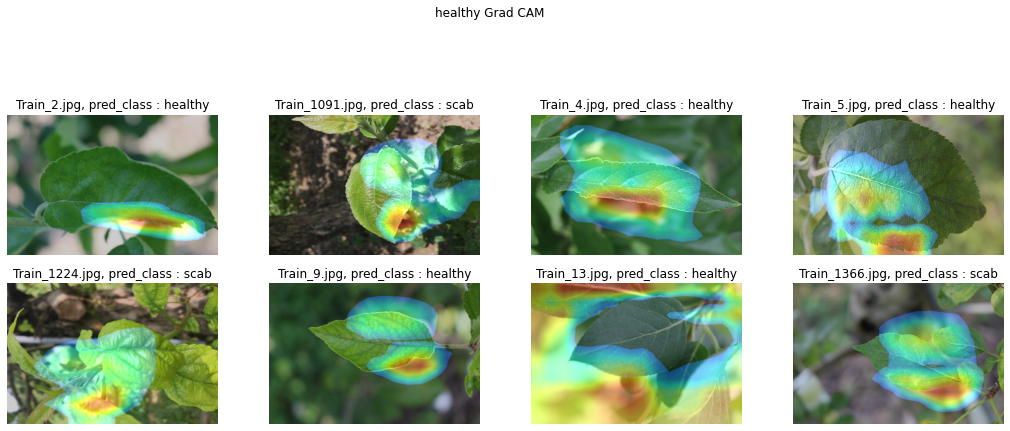

In [ ]:
grad_cam(get_models, 0, CLASSES[0], healthy_list)

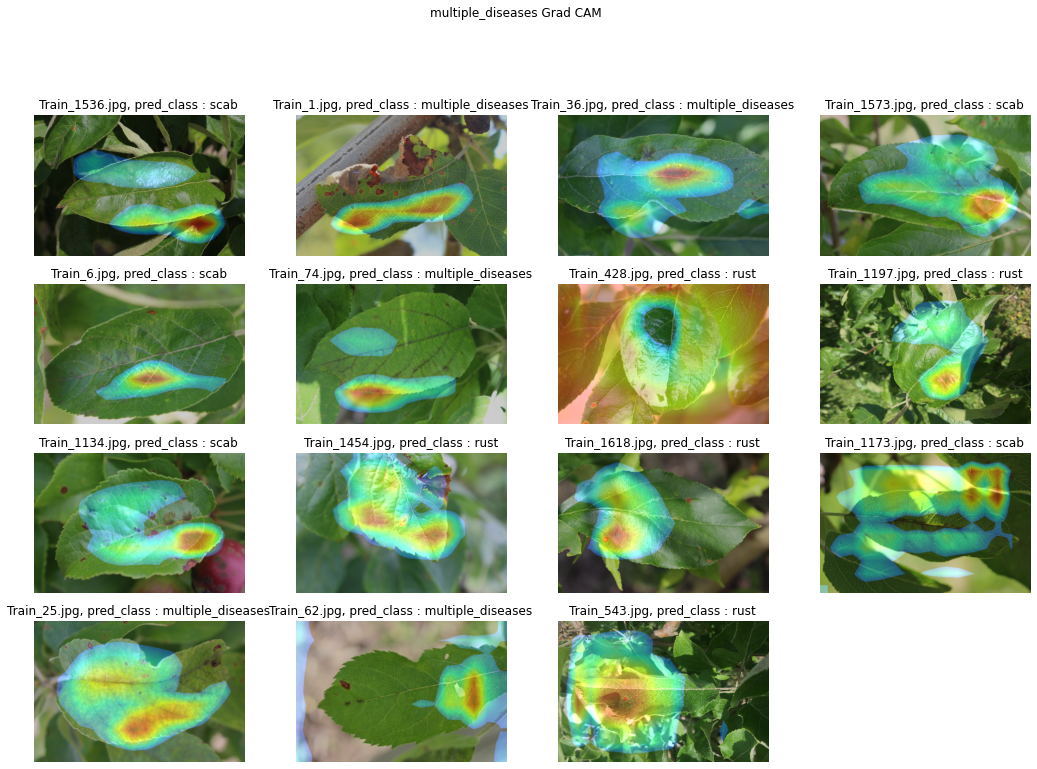

In [ ]:
grad_cam(get_models, 1, CLASSES[1], multiple_diseases_list)

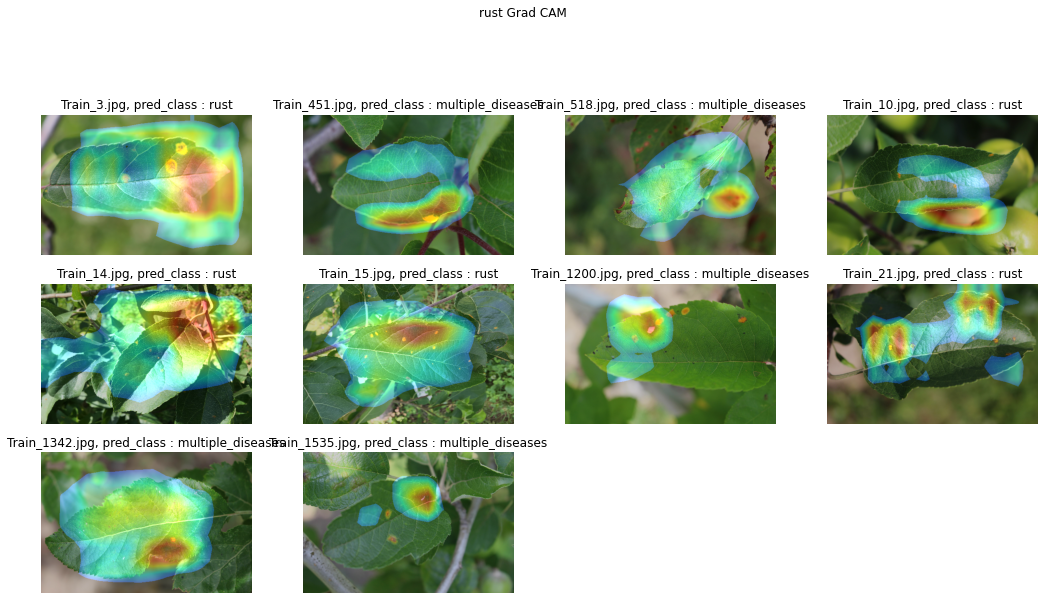

In [ ]:
grad_cam(get_models, 2, CLASSES[2], rust_list)

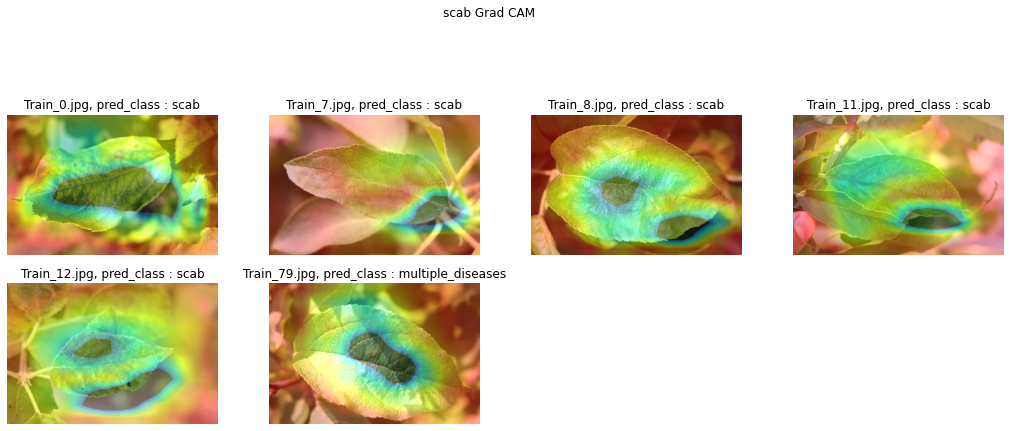

In [ ]:
grad_cam(get_models, 3, CLASSES[3], scab_list)

In [ ]:
#test csv 읽기

testdf = pd.read_csv("/content/gdrive/My Drive/cvpr_data/test.csv")
testdf.head()

image_id
0   Test_0
1   Test_1
2   Test_2
3   Test_3
4   Test_4

In [ ]:
#sample_submission csv 읽기

sampsubmit = pd.read_csv("/content/gdrive/My Drive/cvpr_data/sample_submission.csv")
sampsubmit.head()

image_id  healthy  multiple_diseases  rust  scab
0   Test_0     0.25               0.25  0.25  0.25
1   Test_1     0.25               0.25  0.25  0.25
2   Test_2     0.25               0.25  0.25  0.25
3   Test_3     0.25               0.25  0.25  0.25
4   Test_4     0.25               0.25  0.25  0.25

In [ ]:
#Test images 경로 설정 및 모델 예측 후 이미지명, 예측값 리스트화

from PIL import Image
from tensorflow.keras.preprocessing import image
import cv2

resultlist = []
for i in range(1821):
  if i % 100 == 0:
    print(i, end=', ')
  test_index = 'Test_%d'%i
  test_path = '/content/gdrive/My Drive/cvpr_data/test/' + test_index + '.jpg'
  test_image = Image.open(test_path).resize((IMAGE_SHAPE[1], IMAGE_SHAPE[0]))

  img_tensor = image.img_to_array(test_image)
  img_tensor = np.expand_dims(img_tensor, axis=0)
  test_data = img_tensor / 255.0

  # plt.imshow(test_image)

  # print(test_data.shape)

  predval = get_model.predict(test_data)[0].tolist()
  predval.insert(0, test_index)
  resultlist.append(predval)


0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 

In [ ]:
#commit

resultlist[0:5]

[['Test_0',
  9.506498827249743e-06,
  0.0042191133834421635,
  0.9957640171051025,
  7.344707682932494e-06],
 ['Test_1',
  0.00012067342322552577,
  0.0021583684720098972,
  0.997711181640625,
  9.713259714771993e-06],
 ['Test_2',
  3.302852999778616e-12,
  1.002597173282993e-06,
  3.450717020610748e-14,
  0.9999990463256836],
 ['Test_3',
  0.9999992847442627,
  6.067169238122005e-07,
  6.551180575797844e-08,
  3.0778590343061296e-08],
 ['Test_4',
  4.314930010518303e-11,
  3.328668753965758e-05,
  0.9999667406082153,
  2.7538299418594647e-10]]

In [ ]:
#DataFrame 및 sampsubmit.columns 칼럼 조정.

resultdf = pd.DataFrame(resultlist)
resultdf.columns = sampsubmit.columns
resultdf.head()

image_id       healthy  multiple_diseases          rust          scab
0   Test_0  9.506499e-06       4.219113e-03  9.957640e-01  7.344708e-06
1   Test_1  1.206734e-04       2.158368e-03  9.977112e-01  9.713260e-06
2   Test_2  3.302853e-12       1.002597e-06  3.450717e-14  9.999990e-01
3   Test_3  9.999993e-01       6.067169e-07  6.551181e-08  3.077859e-08
4   Test_4  4.314930e-11       3.328669e-05  9.999667e-01  2.753830e-10

In [ ]:
#제출 양식에 맞게 인덱스 False 설정.

resultdf.to_csv("/content/gdrive/My Drive/CNN/save_csv/EfficientNet/cbam_min2_efficientnet_b0_epoch_80.csv",index=False)